# MNIST

In [1]:
# Import libraries
import torch
import matplotlib.pyplot as plt
torch.manual_seed(8)

# Download and load MNIST dataset

In [2]:
# Download MNIST dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [4]:
print(train_data.data.size())
print(train_data.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


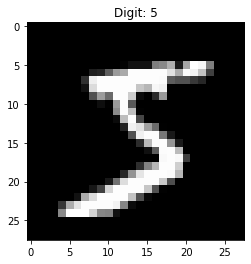

In [5]:
# Plot the first image
plt.imshow(train_data.data[0], cmap='gray')
plt.title("Digit: {}".format(train_data.targets[0]))
plt.show()

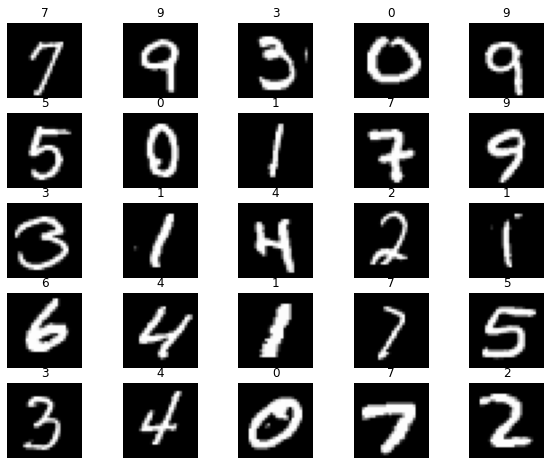

In [6]:
# Plot multiple images
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
# Loop over 25 places to plot the images
for i in range(1, cols * rows + 1):
    # Generate a random index to select an image
    # The item function converts the Tensor object into a scalar value
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    # Extract the image data and target label
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    # Squeeze the image to convert the image shape from [1,28,28] to [28,28]
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
# Preparing data for training with DataLoaders
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, # data source to be loaded
                                          batch_size=100, #  the number of training samples used in one iteration
                                          shuffle=True), # samples are shuffled and loaded in batches
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True)}
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f4548c1d550>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f4548c1da50>}

In [8]:
for X, y in loaders['train']:
    print("Shape of X [batch_size, channel, height, width]: ", X.shape)
    print("Shape of y: ", y.shape)
    break

Shape of X [batch_size, channel, height, width]:  torch.Size([100, 1, 28, 28])
Shape of y:  torch.Size([100])


# Define the prediction function

In [9]:
# Define the Convolutional Neural Network model class
import torch.nn as nn
class CNN(nn.Module):
    # Specify the components to be created automatically upon instantiation
    def __init__(self):
        super(CNN, self).__init__()
        # The first convolutional block
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        # The second convolutional block
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # The final fully connected layer which outputs 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    # Specify the flow of information
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # Flatten the output to shape (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = CNN().to(device)
print(model)

Using cuda device
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [11]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          12,832
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                   [-1, 10]          15,690
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.11
Estimated Total Size (MB): 0.44
----------------------------------------------------------------


In [ ]:
# Using softmax function to transform to probability output
import numpy as np
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

test = [1,2,3]
transformed_test = softmax(test)
print('softmax output:', transformed_test)

softmax output: [0.09003057 0.24472847 0.66524096]


# Define the cost function

In [ ]:
# Define the cross entropy loss function
def cross_entropy(actual, predicted):
    EPS = 1e-15
    # Cap and floor the probability between 0 and 1
    predicted = np.clip(predicted, EPS, 1 - EPS)
    loss = -np.sum(actual * np.log(predicted))
    return loss

In [ ]:
y = np.array([1, 0, 0])
pred_good = np.array([0.8, 0.1, 0.1])
pred_bad = np.array([0.1, 0.6, 0.3])
loss_good = cross_entropy(y, pred_good)
loss_bad = cross_entropy(y, pred_bad)
print('The good prediction loss: {:.4f}'.format(loss_good))
print('The bad prediction loss: {:.4f}'.format(loss_bad))

The good prediction loss: 0.2231
The bad prediction loss: 2.3026


In [ ]:
# Use the default CEL function from the nn module
cost_func = nn.CrossEntropyLoss()  
# The first class starts with index 0
y = torch.tensor([0])
pred_good = torch.tensor([[2, 0.8, 0.5]])
pred_bad = torch.tensor([[1, 6, 0.2]])
loss_good = cost_func(pred_good, y)
loss_bad = cost_func(pred_bad, y)
print('The good prediction loss: {:.4f}'.format(loss_good.item()))
print('The bad prediction loss: {:.4f}'.format(loss_bad.item()))

The good prediction loss: 0.4216
The bad prediction loss: 5.0097


# Define the optimization procedure

In [ ]:
# Define the procedure
from torch import optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)   
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

# Start the training process

In [6]:
# Define the training function
def train(model, loaders, verbose=True):
    # Control the behavior of certain layers by specifying the training mode
    model.train()
    # Extract the total number of images to track training progress
    total_img = len(loaders['train'].dataset)
    # Extract and iterate through each batch of training data
    for batch, (X, y) in enumerate(loaders['train']):
        # Pass to GPU for faster processing
        X, y = X.to(device), y.to(device)
        # Call the forward method (under the hood) to produce prediction
        pred = model(X)               
        # Calculate the current cost
        cost = cost_func(pred, y)
        # Clear existing gradients
        optimizer.zero_grad()           
        # Perform backpropagation and compute gradients 
        cost.backward()    
        # Update weights using SGD
        optimizer.step()       
        # Print cost at every 100th batch; each batch has 100 image-label pairs
        if(verbose):
            if batch % 100 == 0:
                loss, current_img_idx = cost.item(), batch * len(X)
                print(f"cost: {cost:>7f}  [{current_img_idx:>5d}/{total_img:>5d}]")      

In [7]:
# Test the training function for one iteration
# train(model, loaders)

In [8]:
# Define the test function
def test(model, loaders, verbose=True):
    # Control the behavior of certain layers by specifying the evaluation mode
    model.eval()
    # Extract the total number of images to in the test set
    total_img = len(loaders['test'].dataset)
    correct = 0
    # Disable gradient calculation
    with torch.no_grad():
        for X, y in loaders['test']:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # Add the correct prediction for each batch
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= total_img
    if verbose:
        print(f"Test accuracy: {correct:>0.3f}")

# test(model, loaders)

In [ ]:
num_epochs = 100
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(model, loaders, verbose=False)
    test(model, loaders, model)
print("Done!")

Epoch 1
-------------------------------
Test accuracy: 0.911
Epoch 2
-------------------------------
Test accuracy: 0.943
Epoch 3
-------------------------------
Test accuracy: 0.959
Epoch 4
-------------------------------
Test accuracy: 0.967
Epoch 5
-------------------------------
Test accuracy: 0.973
Epoch 6
-------------------------------
Test accuracy: 0.974
Epoch 7
-------------------------------
Test accuracy: 0.975
Epoch 8
-------------------------------
Test accuracy: 0.977
Epoch 9
-------------------------------
Test accuracy: 0.981
Epoch 10
-------------------------------
Test accuracy: 0.980
Done!
